In [1]:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd

In [2]:
file_path="data/mel1_rep1/"
counts=pd.read_csv(file_path+"counts.csv",index_col=0)
coords=pd.read_csv(file_path+"coords.csv",index_col=0)
adata=ad.AnnData(X=counts.values, obs=coords, var=pd.DataFrame(index=counts.columns.values))
adata

AnnData object with n_obs × n_vars = 279 × 15666
    obs: 'array_row', 'array_col'

In [3]:
integral_coords = adata.obs[['array_row','array_col']] # This sentence is enough for most saptial transcriptomic data.

integral_coords.loc["5x10",:]=[5,10] # We add three spots since they are in tissue but missing. 
integral_coords.loc["10x14",:]=[10,14]
integral_coords.loc["15x22",:]=[15,22]

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [5]:
from runDIST_new import getSTtrainset, getSTtestset,get_ST_position_info
import numpy as np
adata.X = adata.X.astype(float)

sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor="seurat")
train_adata = adata[:, adata.var['highly_variable']]

# train_adata=adata[:,adata.var["n_cells_by_counts"]>len(adata.obs.index)*0.1]
train_counts=np.array(train_adata.X)
train_coords=train_adata.obs[['array_row','array_col']]

In [6]:
test_adata=adata[:, adata.var['highly_variable']]
test_counts=np.array(test_adata.X)
test_coords=test_adata.obs[['array_row','array_col']]

In [7]:
train_set=getSTtrainset(train_counts, train_coords)
test_set=getSTtestset(test_counts, test_coords)
position_info=get_ST_position_info(integral_coords)

Creating training set costs:  1.57 s
Creating testing set costs:  1.23 s


In [8]:
from runDIST_new import DIST
imputed_img = DIST(train_set, test_set, epoch=1000, batch_size=512)

[INFO] Using device: cuda
[INFO] Number of genes: 5000
[INFO] DiT Config: hidden_dim=512, num_heads=8, num_layers=5
[INFO] Total parameters: 29,109,792
Start training DiT model...
Epoch [1/1000] Loss: 0.463945
Epoch [10/1000] Loss: 0.273948
Epoch [20/1000] Loss: 0.228826
Epoch [30/1000] Loss: 0.223039
Epoch [40/1000] Loss: 0.221750
Epoch [50/1000] Loss: 0.221267
Epoch [60/1000] Loss: 0.221573
Epoch [70/1000] Loss: 0.220613
Epoch [80/1000] Loss: 0.218701
Epoch [90/1000] Loss: 0.212823
Epoch [100/1000] Loss: 0.205504
Epoch [110/1000] Loss: 0.202247
Epoch [120/1000] Loss: 0.194328
Epoch [130/1000] Loss: 0.182955
Epoch [140/1000] Loss: 0.168766
Epoch [150/1000] Loss: 0.154180
Epoch [160/1000] Loss: 0.140843
Epoch [170/1000] Loss: 0.117732
Epoch [180/1000] Loss: 0.097127
Epoch [190/1000] Loss: 0.083321
Epoch [200/1000] Loss: 0.062846
Epoch [210/1000] Loss: 0.051838
Epoch [220/1000] Loss: 0.040347
Epoch [230/1000] Loss: 0.028593
Epoch [240/1000] Loss: 0.020077
Epoch [250/1000] Loss: 0.013564

In [9]:
from runDIST_new import img2expr
imputed_counts, imputed_coords = img2expr(imputed_img, adata[:, adata.var['highly_variable']].var_names, integral_coords, position_info)
# imputed_counts, imputed_coords = img2expr(imputed_img, adata.var_names, integral_coords, position_info)

In [10]:
imputed_adata=ad.AnnData(X=imputed_counts,obs=imputed_coords)
imputed_adata

AnnData object with n_obs × n_vars = 1060 × 5000
    obs: 'array_row', 'array_col'

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_genes(adata, show_genes, n=4, size=(20,5),point_size=30, titles=None,cmap=None,marker_='s'):
    if titles==None:
        titles=show_genes
    genes_index=[list(adata.var_names).index(gene) for gene in show_genes]
    m=len(show_genes)//n+1
    plt.figure(figsize=size)
    flag=0
    for j in range(m):
        show_genes0=show_genes[j*n:min(len(show_genes),(j+1)*n)]
        
        for i in range(n):
            if not i<len(show_genes0):
                break
            plt.subplot(m,n,flag+1)
        
            plt.scatter(adata.obs['array_row'],adata.obs['array_col'],c=np.array(adata.X)[:,genes_index[flag]],
                        marker=marker_,s=point_size, vmin=0,cmap=cmap)
            plt.title(titles[flag])
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
            flag+=1

In [12]:
adata[:, adata.var['highly_variable']].var_names

Index(['ANXA2', 'DNAH1', 'CCL19', 'EIF4ENIF1', 'RBM8A', 'HMGB1', 'IFT46',
       'MAP1B', 'LITAF', 'CX3CL1',
       ...
       'NAV3', 'SMYD3', 'TMEM187', 'FBXO45', 'NBEA', 'PRTG', 'ZNF14', 'EXTL1',
       'VGF', 'ST6GALNAC2'],
      dtype='object', length=5000)

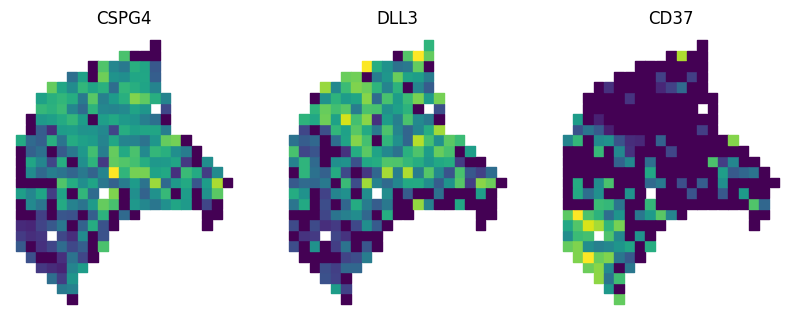

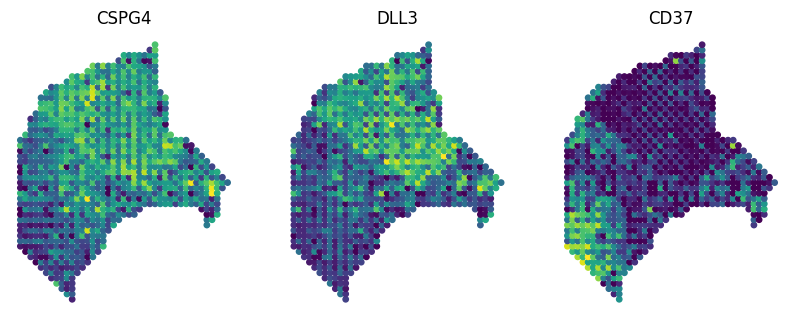

In [13]:
show_genes=['CSPG4','DLL3','CD37']
plot_genes(adata, show_genes, n=3, size=(10,8),point_size=48,marker_='s')
plot_genes(imputed_adata, show_genes, n=3, size=(10,8),point_size=15,marker_='o')